# Decison Support System
### Deciding Factors
- Longevity: time since review
- Length of title and text: count the number of words
- Helpfulness of a review: ratio of “helpful votes” to “total votes”
- Readership: total number of votes of a review
- Select products wtih atleast 100 reviews, eliminated the reviews that had less than 4 votes
- Polarity = positive sentiment + negative sentiment
- Sentiment = positive sentiment - negative sentiment - 2:

In [1]:
import pandas as pd
import numpy as np
import gzip 
import json
import shutil
import time
import math
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def getSentimentsAndLengthFromFile(nameOfFile):
    df=pd.DataFrame()
    file = open(nameOfFile, encoding = "utf8")
    count = 0
    column_names = []
    for line in file:
        count=count+1
        if count is 1:
            column_names = line.split('\t')
            df=pd.DataFrame(columns = column_names)
        temp_line = line.rstrip().split('\t')
        df = df.append(pd.Series(temp_line ,index = column_names), ignore_index = True)
    file.close()
    return df

def unzipJson(filename, saveas):
    "both arguments are strings"
    with gzip.open(filename, 'rb') as f_in:
        with open(saveas, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
def getDataFromJsonFile(filename, noOfRev):
    count = 0
    df = pd.DataFrame()
    with open(filename, 'r') as f:
        for line in f:
            if count == noOfRev:
                break
            count = count + 1
            if count%500==0:
                print(count)
            data = json.loads(line)
            dictionary=json.loads(line)
            dictionary["helpful"] = str(dictionary["helpful"][0])+":"+str(dictionary["helpful"][1])
            df = df.append(pd.DataFrame(dictionary,index = [count]), sort = False)
    return df

def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''
    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')

def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

#### Description of the below cell
- unzip the json.gz file 
- get a dataFrame consisting of 35000 reviews
- store this dataFrame in a csv file
- now this csv file is converted to a txt file that is then
    analysed using the sentistrength software, resulting is a
    txt file having analysed result

In [ ]:
# unzipJson("reviews_Electronics_5.json.gz","reviews_Electronics_5.json")
# df = getDataFromJsonFile("reviews_Electronics_5.json",35000)
# df.to_csv("dataset_electronic.csv")


#### Description of the below cell
- dataset_analysed.txt contains all the analysed data that is converted to a dataFrame
- dataFrame is stored in a csv file for faster access next time


In [ ]:
# data = getSentimentsAndLengthFromFile("dataset_analysed.txt")

In [ ]:
# data = data.drop(0,0)
# data.to_csv("dataset.csv")

In [ ]:
# data['polarityText'] = data['reviewTextPositive'] + data['reviewTextNegative']
# data['polaritySummary'] = data['summaryPositive'] + data['summaryNegative\n']
# data['sentimentText'] = data['reviewTextPositive'] - data['reviewTextNegative']-2
# data['sentimentSummary'] = data['summaryPositive'] - data['summaryNegative\n'] - 2
# data['summaryLength'] = data['summary'].str.split().str.len()
# data['reviewTextLength'] = data['reviewText'].str.split().str.len()
# data['readership'] = data['helpful'].str.split(':').str[1]
# data['longetivity'] = time.time() - data['unixReviewTime']
# del data['no']

In [ ]:
# data.to_csv("dataset.csv")

In [4]:
# read the dataset
data = pd.read_csv('dataset.csv',index_col=0)
data['helpful_votes'] = data['helpful'].str.split(':').str[0]
data['helpful_votes'] = data.helpful_votes.astype(float)
data['longetivity'] = data['longetivity']//86400
# data.head()


In [5]:
# Select products wtih atleast 100 reviews, eliminated the reviews that had less than 4 votes
tempDf = data.groupby('asin').size().rename("countOfReviews").reset_index()
data = data.merge(tempDf)
data = data[data['countOfReviews'] >= 100]
data = data.loc[data['readership'] >= 4]

In [6]:
table1Df = pd.DataFrame(columns=['range', 'median', 'mean', 'SD'], 
                        index = ['Rating', 'Longetivity', 'Total Votes', 'Helpful votes', 'Title sentiment',
                                 'Title polarity', 'Review sentiment', 'Review polarity', 'Title length', 'Review length'])

table1Df.loc['Rating'] = pd.Series({
    'range' : str(data['overall'].min())+'-'+str(data['overall'].max()),
    'median' : data['overall'].median(),
    'mean' : data['overall'].mean(),
    'SD' : data['overall'].std()
})
table1Df.loc['Longetivity'] = pd.Series({
    'range' : str(data['longetivity'].min())+'-'+str(data['longetivity'].max()),
    'median' : data['longetivity'].median(),
    'mean' : data['longetivity'].mean(),
    'SD' : data['longetivity'].std()
})
table1Df.loc['Total Votes'] = pd.Series({
    'range' : str(data['readership'].min())+'-'+str(data['readership'].max()),
    'median' : data['readership'].median(),
    'mean' : data['readership'].mean(),
    'SD' : data['readership'].std()
})
table1Df.loc['Helpful votes'] = pd.Series({
    'range' : str(data['helpful_votes'].min())+'-'+str(data['helpful_votes'].max()),
    'median' : data['helpful_votes'].median(),
    'mean' : data['helpful_votes'].mean(),
    'SD' : data['helpful_votes'].std()
})
table1Df.loc['Title sentiment'] = pd.Series({
    'range' : str(data['sentimentSummary'].min())+'-'+str(data['sentimentSummary'].max()),
    'median' : data['sentimentSummary'].median(),
    'mean' : data['sentimentSummary'].mean(),
    'SD' : data['sentimentSummary'].std()
})
table1Df.loc['Title polarity'] = pd.Series({
    'range' : str(data['polaritySummary'].min())+'-'+str(data['polaritySummary'].max()),
    'median' : data['polaritySummary'].median(),
    'mean' : data['polaritySummary'].mean(),
    'SD' : data['polaritySummary'].std()
})
table1Df.loc['Review sentiment'] = pd.Series({
    'range' : str(data['sentimentText'].min())+'-'+str(data['sentimentText'].max()),
    'median' : data['sentimentText'].median(),
    'mean' : data['sentimentText'].mean(),
    'SD' : data['sentimentText'].std()
})
table1Df.loc['Review polarity'] = pd.Series({
    'range' : str(data['polarityText'].min())+'-'+str(data['polarityText'].max()),
    'median' : data['polarityText'].median(),
    'mean' : data['polarityText'].mean(),
    'SD' : data['polarityText'].std()
})
table1Df.loc['Title length'] = pd.Series({
    'range' : str(data['summaryLength'].min())+'-'+str(data['summaryLength'].max()),
    'median' : data['summaryLength'].median(),
    'mean' : data['summaryLength'].mean(),
    'SD' : data['summaryLength'].std()
})
table1Df.loc['Review length'] = pd.Series({
    'range' : str(data['reviewTextLength'].min())+'-'+str(data['reviewTextLength'].max()),
    'median' : data['reviewTextLength'].median(),
    'mean' : data['reviewTextLength'].mean(),
    'SD' : data['reviewTextLength'].std()
})


## Formula
- log(Total Votes) = B0 + B1 * Title_Sentiment + B2 * TITLE_POSTIVE + B3 * Title_length + B4 * Title_Sentiment * TITLE_POSTIVE + B5 * log(Review_Length) + B6 * log(Longevity)

In [7]:
data
table1Df


,range,median,mean,SD
Rating,1.0-5.0,4,3.75608,1.50318
Longetivity,1710.0-6887.0,4082,4033.06,1169.66
Total Votes,4-1591,7,24.1913,69.5943
Helpful votes,0.0-1556.0,6,20.6897,66.8541
Title sentiment,0-5,1,1.11111,1.0663
Title polarity,-4-4,0,0.578567,1.24204
Review sentiment,0-8,3,3.17094,1.44084
Review polarity,-3-4,0,0.350427,1.15912
Title length,1-23,5,5.1716,2.85392
Review length,9.0-2079.0,121,176.77,178.095


In [8]:
readerData = pd.DataFrame()
readerData['Title_Sentiment'] = data['sentimentSummary']
readerData['TITLE_POSITIVE'] = data['polaritySummary']
readerData.loc[readerData['TITLE_POSITIVE'] > 0,'temp'] = 1
readerData.loc[readerData['TITLE_POSITIVE'] <= 0,'temp'] = 0
readerData['TITLE_POSITIVE'] = readerData['temp']
del readerData['temp']
readerData['Title_Length'] = data['summaryLength']
readerData['B4_mul'] = readerData['Title_Sentiment'] * readerData['TITLE_POSITIVE']
readerData['B5_mul'] = np.log(data['reviewTextLength'])
readerData['B6_mul'] = np.log(data['longetivity'])
readerData['TITLE_POSITIVE'] = data['summaryPositive']
logTotalVotes = np.log10(data['readership'])

In [9]:
reg_for_reader = LinearRegression().fit(readerData, logTotalVotes)

In [10]:
readerData['logTotalVotes'] = logTotalVotes
reg_for_reader.coef_
# reg_for_reader.intercept_ 

array([-0.01047036, -0.07413579,  0.0048672 ,  0.04432912,  0.09628507,
        0.42113113])

In [11]:
helpful = pd.DataFrame()
helpful['Review_Sentiment'] = data['sentimentText']
helpful['REVIEW_NEUTRAL'] = data['polarityText']
helpful.loc[helpful['REVIEW_NEUTRAL'] == 0,'temp'] = 1
helpful.loc[helpful['REVIEW_NEUTRAL'] != 0,'temp'] = 0
helpful['REVIEW_NEUTRAL'] = helpful['temp']
del helpful['temp']
helpful['B3_mul'] = np.log(data['reviewTextLength'])
helpful['B4_mul'] = helpful['Review_Sentiment']*helpful['REVIEW_NEUTRAL']
helpful['B5_mul'] = np.log(data['longetivity'])
numerator = data['helpful'].str.split(':',n=1,expand=True)[0].astype(float)
denominator = data['helpful'].str.split(':',n=1,expand=True)[1].astype(float)
ratio=numerator/denominator

In [14]:
reg_for_helpful = LinearRegression().fit(helpful, ratio)

In [15]:
helpful['ratio'] = ratio
reg_for_helpful.coef_
print("This is for readership:",reg_for_reader.coef_)
print("This is for helpfulness:",reg_for_helpful.coef_)


This is for readership: [-0.01047036 -0.07413579  0.0048672   0.04432912  0.09628507  0.42113113]
This is for helpfulness: [ 0.00076336  0.03574834  0.10071268 -0.01218942  0.19693551]


### Summary of Hypothesis testing

In [18]:
table2Df = pd.DataFrame(columns=['Hypothesized relationship', 'Estimates (Wald Chi-square)', 'Results'], 
                        index = ['H1','H2','H3','H4','H5','H6','H7','H8'])

obs = np.array([data['longetivity'], data['readership']])
chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H1'] = pd.Series({
    'Hypothesized relationship' : 'Longevity → readership',
    'Estimates (Wald Chi-square)': str(reg_for_reader.coef_[5]) +'(' + str(chi2) + ')',
    'Results':'Supported'
})

obs = np.array([data['sentimentSummary'], data['readership']])
chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H2'] = pd.Series({
    'Hypothesized relationship' : 'Title sentiment → readership',
    'Estimates (Wald Chi-square)': str(reg_for_reader.coef_[0]) +'(' + str(chi2) + ')',
    'Results':'Not Supported'
})

obs = np.array([readerData['B4_mul'], data['readership']])
chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H3'] = pd.Series({
    'Hypothesized relationship' : 'Title sentiment × title positive → readership',
    'Estimates (Wald Chi-square)': str(reg_for_reader.coef_[3]) +'(' + str(chi2) + ')',
    'Results':'Supported'
})

obs = np.array([data['summaryLength'], data['readership']])
chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H4'] = pd.Series({
    'Hypothesized relationship' : 'Title length → readership',
    'Estimates (Wald Chi-square)': str(reg_for_reader.coef_[2]) +'(' + str(chi2) + ')',
    'Results':'Supported'
})

obs = np.array([data['reviewTextLength'], data['readership']])
chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H5'] = pd.Series({
    'Hypothesized relationship' : 'Review length → readership',
    'Estimates (Wald Chi-square)': str(reg_for_reader.coef_[4]) +'(' + str(chi2) + ')',
    'Results':'Supported'
})

obs = np.array([data['reviewTextLength'], ratio])
chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H6'] = pd.Series({
    'Hypothesized relationship' : 'Review length → helpfulness',
    'Estimates (Wald Chi-square)': str(reg_for_helpful.coef_[2]) +'(' + str(chi2) + ')',
    'Results':'Supported'
})

# this has error below
obs = np.array([data['sentimentText'], ratio])
# chi2, p, dof, expected = chi2_contingency(obs)
# till here
table2Df.loc['H7'] = pd.Series({
    'Hypothesized relationship' : 'Review sentiment → helpfulness',
    'Estimates (Wald Chi-square)': str(reg_for_helpful.coef_[0]) +'(' + str(chi2) + ')',
    'Results':'Supported'
})

obs = np.array([helpful['B4_mul'], ratio])
# chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H8'] = pd.Series({
    'Hypothesized relationship' : 'Review sentiment × review neutral → helpfulness',
    'Estimates (Wald Chi-square)': str(reg_for_helpful.coef_[3]) +'(' + str(chi2) + ')',
    'Results':'Not Supported'
})


table2Df

,Hypothesized relationship,Estimates (Wald Chi-square),Results
H1,Longevity → readership,0.4211311319315969(223815.3744602637),lol
H2,Title sentiment → readership,-0.010470360971566594(6685.274522871434),lol
H3,Title sentiment × title positive → readership,0.04432911588570552(6894.838509864072),lol
H4,Title length → readership,0.004867197057274018(11880.108455434216),lol
H5,Review length → readership,0.09628507394913086(83975.97214680901),lol
H6,Review length → helpfulness,0.10071268078797378(1320.9829035426203),lol
H7,Review sentiment → helpfulness,0.0007633629153438244(1320.9829035426203),lol
H8,Review sentiment × review neutral → helpfulness,-0.012189419357290107(1320.9829035426203),lol


In [15]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewTextPositive,...,polarityText,polaritySummary,sentimentText,sentimentSummary,summaryLength,reviewTextLength,readership,longetivity,helpful_votes,countOfReviews
22,AVRFGGCCCR6QU,0972683275,"""Alberto Dieguez """"premiere purchaser of rando...",3:4,This wall mount does everything it's supposed ...,4.0,Fairly good wall mount,1283126400,"08 30, 2010",1,...,0,1,0,1,4,81.0,4,3109.0,3.0,219
26,A26QCCO0101CO1,0972683275,"""Amazon Customer """"jkhinch""""""",7:9,I used this for my 47&#34; Samsung. Its fit/fe...,5.0,Just what I'd hoped,1361404800,"02 21, 2013",3,...,1,1,3,1,4,79.0,9,2203.0,7.0,219
56,A3QH8VQDE7HZCR,0972683275,costaricachris,15:19,Quality was excellent. Instructions were clear...,5.0,Real value for the money,1286236800,"10 5, 2010",4,...,3,1,3,1,5,64.0,19,3073.0,15.0,219
82,A38FGQVJM18OWV,0972683275,"""George S. Mitchell """"gsmitchell""""""",8:18,I checked around Amazon as well as some other ...,1.0,What a piece of junk!,1291161600,"12 1, 2010",2,...,0,-1,2,1,5,138.0,18,3016.0,8.0,219
141,A7R4R9THNELTP,0972683275,LG,14:19,"""I mounted this in my RV and it holds a 26"""" L...",5.0,"Excellent, at any price",1285804800,"09 30, 2010",3,...,0,3,4,3,4,47.0,19,3078.0,14.0,219


### Graphs
#### The below contains 4 graphs as in the paper 

- polartiyText : ReviewPolarity
- sentimentText : ReviewSentiment
- polaritySummmary : TitlePolarity
- Title_Sentiment : TitleSentiment

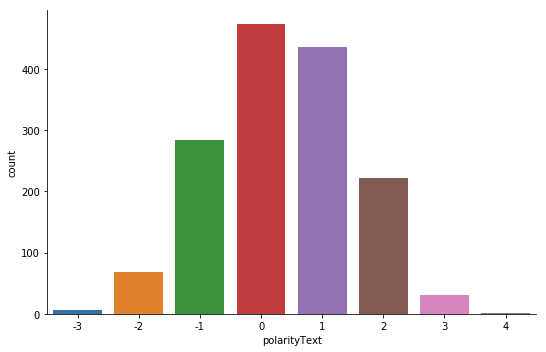

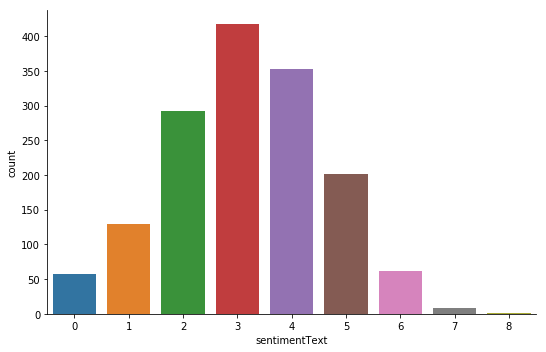

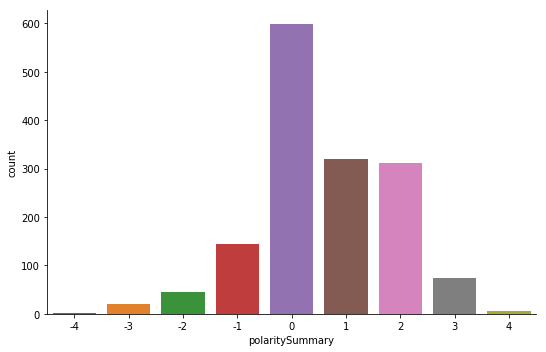

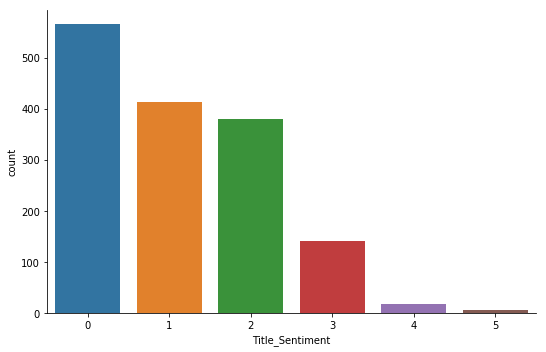

In [19]:
g = sns.catplot(x='polarityText',data=data, kind='count', aspect=1.5)
g = sns.catplot(x='sentimentText',data=data, kind='count', aspect=1.5)
g = sns.catplot(x='polaritySummary',data=data, kind='count', aspect=1.5)
g = sns.catplot(x='Title_Sentiment',data=readerData, kind='count', aspect=1.5)

In [45]:
from scipy.stats import chi2_contingency
obs = np.array([[25, 75], [100, 100]])
obs
# chi2, p, dof, expected = chi2_contingency(obs)
# print(chi2, p, dof, expected)

array([[ 25,  75],
       [100, 100]])

In [71]:
# a = [2, 5]
# b = [7, 6]

# obs = np.array([data['longetivity'], data['readership']])
# # obs
# chi2, p, dof, expected = chi2_contingency(obs)

# obs = np.array([data['sentimentSummary'], data['readership']])
# chi2, p, dof, expected = chi2_contingency(obs)
# print(chi2, p, dof)
helpful['Review_Sentiment']

22       0
26       3
56       3
82       2
141      4
145      3
155      2
156      2
167      5
201      1
211      3
221      1
223      3
230      3
232      3
362      2
363      4
366      3
369      5
370      0
376      5
377      4
378      5
380      4
382      4
383      4
384      4
385      6
387      6
389      3
        ..
32854    2
32931    3
32940    3
32950    2
33107    2
33146    3
33218    3
33222    0
33232    1
33344    0
33348    1
33351    0
33403    1
33460    2
33487    3
33493    2
33506    3
33854    3
33869    1
33906    5
33914    5
33923    3
33941    3
33963    1
33998    0
34000    2
34022    2
34113    2
34160    2
34199    2
Name: Review_Sentiment, Length: 1521, dtype: int64